In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from math import sqrt
import seaborn as sns
sns.set()

In [2]:
csv_data = pd.read_csv('Index2018.csv')
df_copy = csv_data.copy()
df_copy.date = pd.to_datetime(df_copy.date, dayfirst = True)
df_copy.set_index('date', inplace = True)
df_copy = df_copy.asfreq('b')
df_copy = df_copy.fillna(method = 'ffill')

In [3]:
df_copy['market_value'] = df_copy.ftse
df_copy.head()

,spx,dax,ftse,nikkei,market_value
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,3445.98
1994-01-10,475.27,2225.00,3440.58,18443.44,3440.58
1994-01-11,474.13,2228.10,3413.77,18485.25,3413.77
1994-01-12,474.17,2182.06,3372.02,18793.88,3372.02
1994-01-13,472.47,2142.37,3360.01,18577.26,3360.01


In [4]:
for i in df_copy:
    if i != 'market_value':
        del df_copy[i]
    else:
        df_copy.head()
size = int(len(df_copy)*0.8)


In [5]:
df_train, df_test = df_copy.iloc[:size], df_copy.iloc[size:]

# LLR Test

In [6]:
#Función para comparar modelos
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p
    

# Creando los retornos

In [7]:
#Los retornos se crean para obtener una serie estacionaria porque la serie de precios no es estacionaria
#Los retornos en este caso es el porcentaje de cambio de un día respecto al anterior
df_train['returns'] = df_train.market_value.pct_change(1)*100
df_train.head()

<ipython-input-7-b6b009fa2637>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.market_value.pct_change(1)*100


,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


# ACF PARA RETORNOS

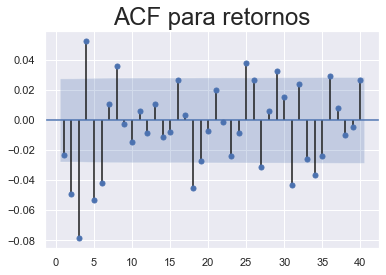

In [8]:
#Pasamos desde la posición 1 porque el primer valor es nan
sgt.plot_acf(df_train.returns[1:], zero = False, lags = 40)
plt.title('ACF para retornos', size = 24)
plt.show()
#Para este caso la función de autocorrelación demuestra que los primeros días son importantes
#además de esto en los negativos la autocorrelación puede indicar que se esta haciendo un ajuste de los precios
#lo cual no es de preocupar si no que es algo que pasa de manera natural en los mercados

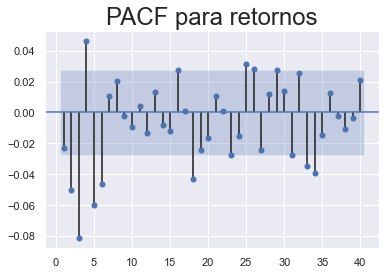

In [9]:
sgt.plot_pacf(df_train.returns[1:], zero = False, lags = 40, method =('ols'))
plt.title('PACF para retornos', size = 24)
plt.show()
#Para este caso las graficas pueden indicar que los precios varian en la dirección opuesta de los precios 
#de ej 1 día.

# MA(1) RETURNS 


In [10]:
#Para este caso tomaremos 1 retraso para la tabla de retornos 
#en el order se pasara como 0 si no queremos tomar valores de AR 
#y en el caso de 1 para un retorno de MA (medias moviles)

model_ret_ma_1 = ARMA(df_train.returns[1:], order = (0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
#Resumen de los resultados
results_ret_ma_1.summary()
#El coeficiente para este caso es del 8%

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Fri, 29 Oct 2021   AIC                          15865.190
Time:                        21:07:32   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""

# Modelos de medias moviles para más de 1 retorno

In [11]:
model_ret_ma_2 = ARMA(df_train.returns[1:], order= (0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print(f'Evaluación del modelo test p-valor {LLR_test(results_ret_ma_1, results_ret_ma_2)}')

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 2)   Log Likelihood               -7922.864
Method:                       css-mle   S.D. of innovations              1.173
Date:                Fri, 29 Oct 2021   AIC                          15853.728
Time:                        21:07:32   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.239      0.215      -0.011       0.049
ma.L1.returns    -0.0327      0.014     -2.297      0.022      -0.061      -0.005
ma.L2.returns    -0.0502      0.014     

In [12]:
model_ret_ma_3 = ARMA(df_train.returns[1:], order = (0,3))
result_ret_ma3 = model_ret_ma_3.fit()
print(result_ret_ma3.summary())
print(f'Evaluación del modelo test p-valor {LLR_test(results_ret_ma_2, result_ret_ma3)}')
#Para este caso si el p valor es menor a 0.05 entonces un modelo es mejor que el otro

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 3)   Log Likelihood               -7904.317
Method:                       css-mle   S.D. of innovations              1.168
Date:                Fri, 29 Oct 2021   AIC                          15818.634
Time:                        21:07:32   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0203      0.014     -1.423      0.155      -0.048       0.008
ma.L2.returns    -0.0556      0.013     

In [13]:
model_ret_ma_4 = ARMA(df_train.returns[1:], order = (0,4))
result_ret_ma_4 = model_ret_ma_4.fit()
print(result_ret_ma_4.summary())
print(f'P-valor {LLR_test(result_ret_ma3, result_ret_ma_4)}')

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 4)   Log Likelihood               -7898.773
Method:                       css-mle   S.D. of innovations              1.167
Date:                Fri, 29 Oct 2021   AIC                          15809.547
Time:                        21:07:33   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.305      0.192      -0.009       0.047
ma.L1.returns    -0.0203      0.014     -1.443      0.149      -0.048       0.007
ma.L2.returns    -0.0551      0.014     

In [14]:
model_ret_ma_8 = ARMA(df_train.returns[1:], order = (0,8))
results_ret_ma_8 = model_ret_ma_8.fit()
print(results_ret_ma_1.summary)
print('P Valor o prueba de LLR de los modelos {}'.format(LLR_test(result_ret_ma_4, results_ret_ma_8, DF=4)))

<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARMAResults object at 0x000001F2B83045E0>>
P Valor o prueba de LLR de los modelos 0.0


# Residuos para los retornos

In [15]:
#Nueva columna
df_train['res_ret_ma_8'] = results_ret_ma_8.resid[1:]

<ipython-input-15-d6cbbf83205f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['res_ret_ma_8'] = results_ret_ma_8.resid[1:]


In [18]:
print(f'La media de los residuos es: {round(df_train.res_ret_ma_8.mean(),3)} \nY la varianca de los residuos es:      {round(df_train.res_ret_ma_8.var(), 3)}')

La media de los residuos es: -0.0 
Y la varianca de los residuos es:      1.356


In [20]:
#Desviación tipica (raiz cuadrada de la varianza)
round(sqrt(df_train.res_ret_ma_8[1:].var()),3)


1.164

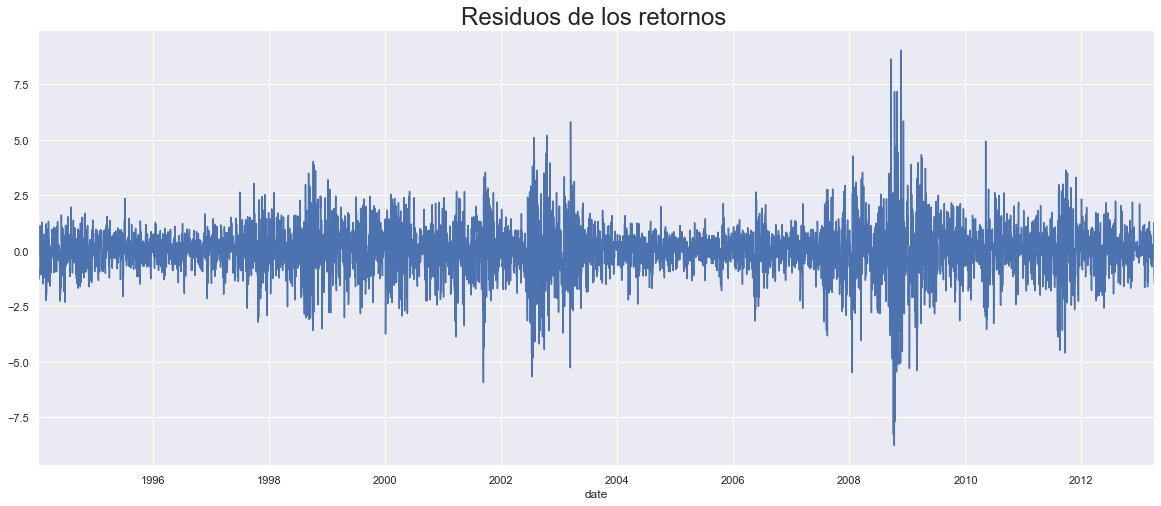

In [22]:
#Aqui debe estar normalizado al estandar Gaussiano, en este caso tomamos la desviación tipica que es 
# 3 * sigma y -3*sigma donde sigma es la desviación tipica
#ej 3*1.164, la grafica debe tomar un rango dentro de 3.5 y -3.5 
df_train.res_ret_ma_8[1:].plot(figsize = (20,8))
plt.title('Residuos de los retornos ', size = 24)
plt.show()

In [24]:
#Calculando la estacionariedad para ver si los valores son estacionarios 
#Qué es una caracteristica del ruido blanco, que es lo que se busca
sts.adfuller(df_train.res_ret_ma_8[2:])

(-70.83581834246827,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052184974693)

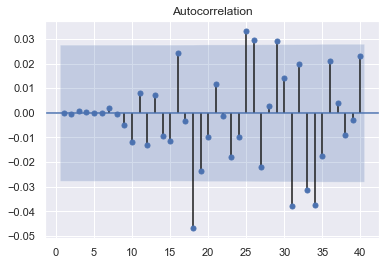

In [28]:
#Haciendo pruebas de autocorrelacion para comprobar si es ruido blanco o no, en este caso la grafica debe 
#devolver todos los puntos en el segmento azul
sgt.plot_acf(df_train.res_ret_ma_8[2:], zero = False, lags = 40)
plt.show()